<a href="https://colab.research.google.com/github/RajeshNN/neural-style-transfer/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer using pretrained Torchvision model...

### Importing libraries...

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import requests
import IPython.display as display

%matplotlib inline

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

In [ ]:
from torchvision.models import vgg
import torchvision.transforms as transforms

### Importing content and style images...

In [ ]:
img2 = Image.open(requests.get("https://miro.medium.com/max/6976/1*RSyYDJNqbMEZfe7khWnJ6A.jpeg", stream = True).raw)
img = Image.open(requests.get("https://media1.s-nbcnews.com/j/newscms/2020_42/3419312/201012-gal-gadot-mc-1221_212dac7f3c5f52bf68273830d965ed84.fit-760w.JPG", stream = True).raw)

(-0.5, 759.5, 545.5, -0.5)

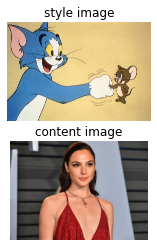

In [ ]:
fig, ax = plt.subplots(2)
ax[0].axis('off')
ax[0].imshow(img2)
ax[0].set_title('style image')
ax[1].imshow(img)
ax[1].set_title('content image')
ax[1].axis('off')

### Defining device and importing torchvision model...

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model = vgg.vgg19(pretrained = True).features.to(device).eval()

In [ ]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Preparing images and sending to device...

In [ ]:
content_image = np.asarray((img.resize((400,300), Image.ANTIALIAS)))
style_image = np.asarray((img2.resize((400,300), Image.ANTIALIAS)))

In [ ]:
content_image = torch.from_numpy(content_image.transpose(2, 0, 1)).type(torch.FloatTensor)
content_image = content_image.unsqueeze(0).to(device)
style_image = torch.from_numpy(style_image.transpose(2, 0, 1)).type(torch.FloatTensor)
style_image = style_image.unsqueeze(0).to(device)

### Choosing Style layer contributions and defining content cost and style cost functions and forward hook functions to extract activation layers of the model...

In [ ]:
STYLE_LAYERS = [
                (3, 'conv1_2', 0.2),
                (8, 'conv2_2', 0.2),
                (13, 'conv3_2', 0.2),
                (22, 'conv4_2', 0.2),
                (31, 'conv5_2', 0.2),
                ]

CONTENT_LAYER = [(29, 'conv5_1', 1.0)]

In [ ]:
def Compute_Content_Cost(content_activation, input):
  return F.mse_loss(input, content_activation)

In [ ]:
def gram_matrix(A):
  a, b, c, d = A.shape
  f = A.view(a * b, c * d)
  GA = torch.mm(f, f.t())
  return GA.div(a * b * c * d)

In [ ]:
def Compute_Style_Cost(style_activations, input_activations, STYLE_LAYERS):
  J_style = 0
  for layer, layer_name, coeff in STYLE_LAYERS:
    style_matrix = gram_matrix(style_activations[layer])
    J_style += coeff * (F.mse_loss(gram_matrix(input_activations[layer]), style_matrix)).to(device)
  return J_style

In [ ]:
def get_activation(layer):
    def hook(model, input, output):
        activation[layer] = output.detach()   #note use of .detach() to remove the variable out of backpropagation graph
    return hook                               #these set of activations remain constant while generation of image

def get_activation_(layer):
    def hook(model, input, output):
        activation[layer] = output
    return hook

### Extracting relevant activation layers for content cost and style cost evaluation and visualizing some of them...

In [ ]:
activation = {}
for layer, _, _ in CONTENT_LAYER:
  model[layer].register_forward_hook(get_activation(layer))
content_out = model(content_image)
a_C = activation[CONTENT_LAYER[0][0]]

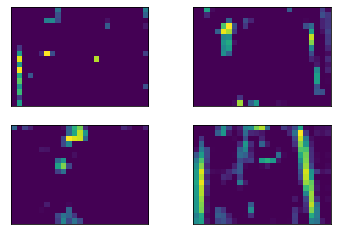

In [ ]:
square = 2
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(a_C.cpu()[0,ix+40,:,:])
        ix += 1


In [ ]:
activation = {}
for layer, _, _ in STYLE_LAYERS:
  model[layer].register_forward_hook(get_activation(layer))
style_out = model(style_image)
style_activations = activation

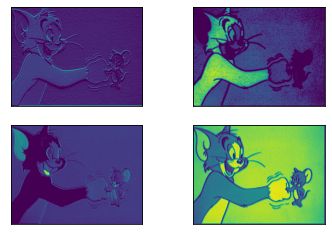

In [ ]:
square = 2
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(style_activations[3][0,ix-1,:,:].cpu())
        ix += 1


### Defining initial image to train...

In [ ]:
generated_image = torch.tensor(content_image, requires_grad=True, device= device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [ ]:
print(generated_image.is_leaf, generated_image.requires_grad)

True True


### Defining function to display images from tensors...

In [ ]:
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):

    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = ((image - image.min()) /(image.max() - image.min()))
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    #display.display(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

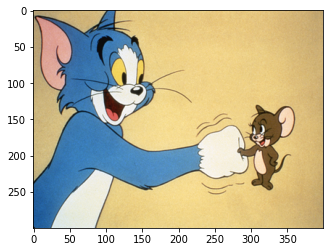

In [ ]:
imshow(style_image)

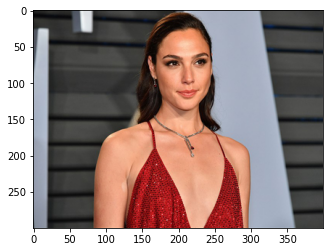

In [ ]:
imshow(generated_image)

### Choosing optimizing technique and learning rate...

In [ ]:
optimizer = optim.Adam([generated_image], lr = 2.0)

In [ ]:
generated_image.requires_grad

True

### Defining content and style contributions, alpha and beta, and generating the image...

In [ ]:
alpha = 15
beta = 40
num_iter = 100

Iteration 0 :
total cost = tensor(378341.2500, device='cuda:0', grad_fn=<AddBackward0>)
content cost = tensor(0., device='cuda:0', grad_fn=<MseLossBackward>)
style cost = tensor(9458.5312, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 20 :
total cost = tensor(151066.3594, device='cuda:0', grad_fn=<AddBackward0>)
content cost = tensor(217.7343, device='cuda:0', grad_fn=<MseLossBackward>)
style cost = tensor(3695.0088, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 40 :
total cost = tensor(70425.2344, device='cuda:0', grad_fn=<AddBackward0>)
content cost = tensor(139.1062, device='cuda:0', grad_fn=<MseLossBackward>)
style cost = tensor(1708.4661, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 60 :
total cost = tensor(32880.0547, device='cuda:0', grad_fn=<AddBackward0>)
content cost = tensor(105.3747, device='cuda:0', grad_fn=<MseLossBackward>)
style cost = tensor(782.4859, device='cuda:0', grad_fn=<AddBackward0>)
Iteration 80 :
total cost = tensor(16566.9512, device='cuda:0'

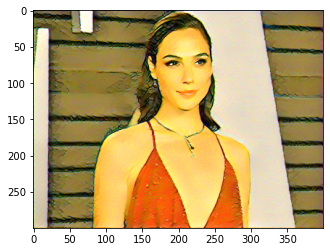

In [ ]:
for i in range(num_iter):
  generated_image.data.clamp_(0,255)
  activation = {}
  for layer, _, _ in (STYLE_LAYERS + CONTENT_LAYER):
    model[layer].register_forward_hook(get_activation_(layer))
  out = model(generated_image)

  optimizer.zero_grad()
  
  J_style = Compute_Style_Cost(style_activations, activation, STYLE_LAYERS)
  J_content = Compute_Content_Cost(a_C, activation[CONTENT_LAYER[0][0]])
  loss = (J_content * alpha) + (J_style * beta)

  loss.backward()
  optimizer.step()
  
  # Print every 20 iteration.
  if i%20 == 0:
    print("Iteration " + str(i) + " :")
    print("total cost = " + str(loss))
    print("content cost = " + str(J_content))
    print("style cost = " + str(J_style))

generated_image.data.clamp_(0,255)

imshow(generated_image)

In [ ]:
p = generated_image.squeeze(0).detach().cpu().numpy().transpose(1,2,0)

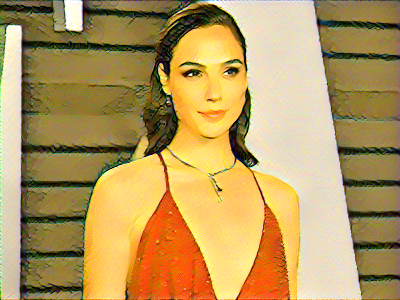

In [ ]:
Image.fromarray(np.uint8(p)).convert('RGB')